In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import segyio
import scipy as sp

from matplotlib.patches import Rectangle

from refrtomo.segyshot import SegyShot, rotate
from refrtomo.utils import *

# First Arrival Picking

In this notebook, we will be looking at the problem of first arrival picking. This is a common problem in seismic data processing, where we are interested in identifying the first arrival of a seismic wave in a seismic trace. The first arrivals come from the refracted waves that take the fastest path through the subsurface, and then can be matched with the traveltimes of the rays, as shown in the next notebooks.

Import the common shot gathers segy file and the velocity model.

In [2]:
# Import the 2D seismic data and 3D Velocity model
inputfile = '../data/ST10010_1150780_40203_2dline1.sgy'
velfile = '../data/ST10010ZC11-MIG-VEL.MIG_VEL.VELOCITY.3D.JS-017527.segy'

# Open the 2D seismic data
f = segyio.open(inputfile, ignore_geometry=True)

In [3]:
# Number of traces
nTraces = f.bin[segyio.BinField.Traces]
print(f"Number of traces = {nTraces}")

# Create the SegyShot object
sg = SegyShot(inputfile, components=['P', 'VZ', 'VX', 'VY'])
# Scan the shot gathers and get attributes
sg.interpret()

# Get time axis
t = sg.t
dt = t[1] - t[0]
print(f"dt = {dt} ms")

# Store attributes
nSrc = sg.nsrc  # number of sources
nRec = sg.nrec  # number of receivers
nT = sg.nt      # number of time samples

print(f"Number of sources = {nSrc}")
print(f"Number of receivers = {nRec}")
print(f"Number of time samples = {nT}")

Number of traces = 960
dt = 0.002 ms
Number of sources = 30
Number of receivers = 240
Number of time samples = 2000


In [4]:
# Open the 3D velocity model
fv = segyio.open(velfile)

# Depth axes
z = fv.samples[0:186]
il, xl = fv.ilines, fv.xlines

# Create the 3D Array with the velocity model
vmod = segyio.cube(velfile)
print(f"3D velocity model shape {vmod.shape}")

# Select the closest inline to geometry of the 2D seismic data
inline = 10
vmod2d = vmod[inline, 50:190, 0:186] # Short it laterally and vertically

# Extract the velocity local coordinates
with segyio.open(velfile, "r") as vel:
    scvel = vel.header[0][segyio.TraceField.SourceGroupScalar]
    if scvel < 0:
        scvel = 1. / abs(scvel)
    xvel = scvel * vel.attributes(segyio.TraceField.CDP_X)[xl.size*(inline):xl.size*(inline+1)]
    yvel = scvel * vel.attributes(segyio.TraceField.CDP_Y)[xl.size*(inline):xl.size*(inline+1)]
    rot, ox, oy = segyio.tools.rotation(vel, line='fast')
    ox, oy = scvel * ox, scvel * oy
    rot = (rot - np.pi / 2)

    xvel_local, yvel_local = rotate(xvel, yvel, ox, oy, rot)

# Short laterally the x, y coordiantes
xvel_local = xvel_local[50:190]
yvel_local = yvel_local[50:190]

3D velocity model shape (109, 241, 226)


Use the velocity model to rotate our dataset in order to align our sources and receivers to the 'x axis'.

Local regular axis:
 ox=0.000000, dx=49.793406 nx=241
 oy=-0.000000, dy=49.540976 ny=109


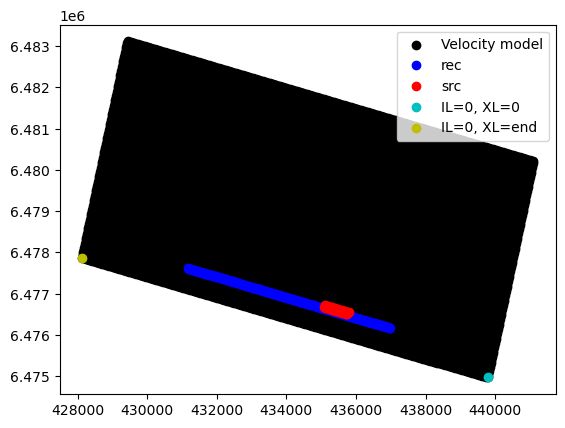

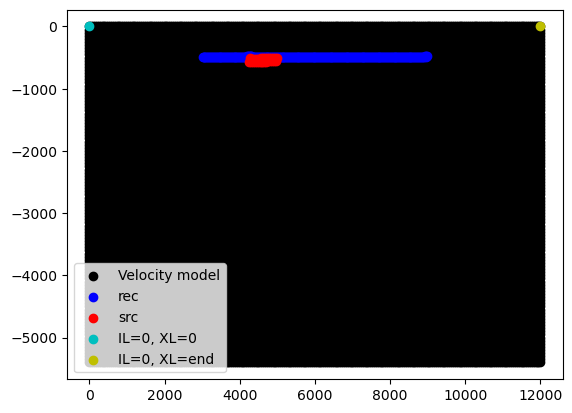

<Figure size 640x480 with 0 Axes>

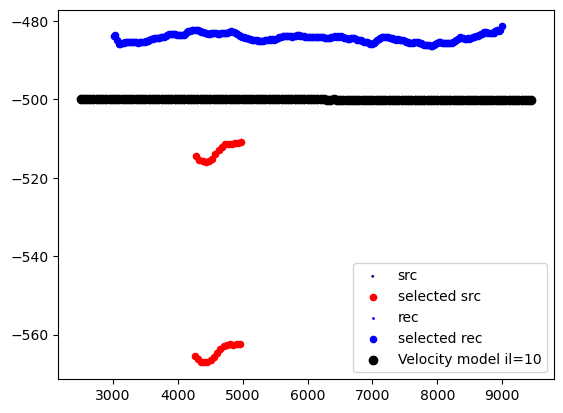

In [5]:
# Convert the geometry to local, rectangular coordinates
sg.rotategeometry(velfile=velfile, plotflag=1)  # inline 10 is the inline of the 2D line

plt.figure()
sg.showgeometry(local=True)
plt.scatter(xvel_local, yvel_local, color='k', label=f'Velocity model il={inline}')
plt.legend()
plt.show()

Show the inline 10 slice of the migration velocity model.

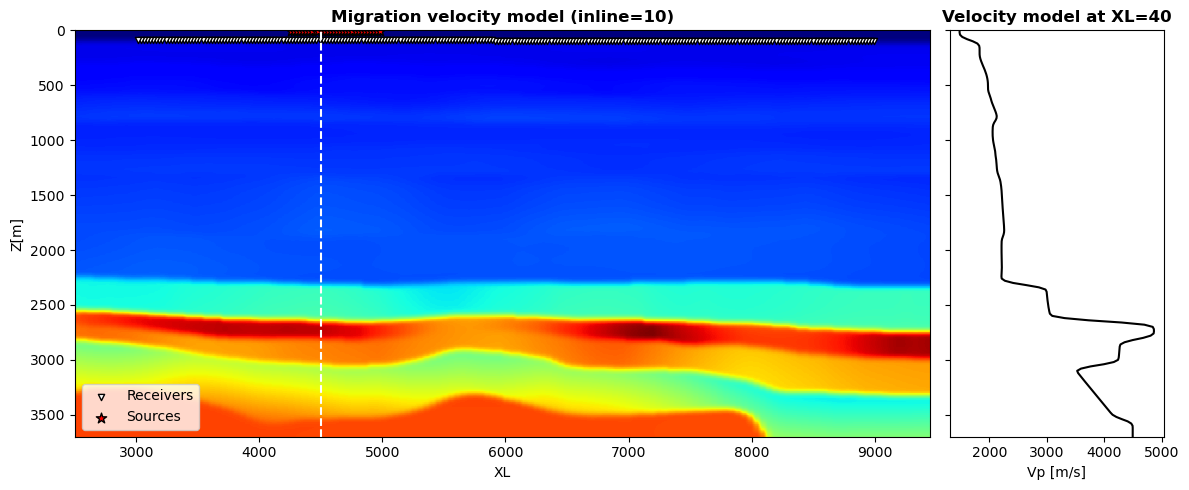

In [6]:
# Display velocity model
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True, gridspec_kw={'width_ratios': [4, 1]})

# Plot migration velocity model
axs[0].imshow(vmod2d.T, extent=(xvel_local[0], xvel_local[-1], z[-1], z[0]), cmap='jet')
# Show receivers and sources
axs[0].scatter(sg.recx_local, sg.recz, marker='v', s=20, c='w', edgecolors='k', label='Receivers')
axs[0].scatter(sg.srcx_local, sg.srcz, marker='*', s=60, c='r', edgecolors='k', label='Sources')
# Highlight the crossline
axs[0].axvline(xvel_local[40], color='w', linestyle='--')
axs[0].set_title(f'Migration velocity model (inline={inline})', fontweight='bold')
axs[0].set_xlabel('XL')
axs[0].set_ylabel('Z[m]')
axs[0].axis('tight')
axs[0].legend()

# Plot velocity profile at XL=40
axs[1].plot(vmod2d[40], z, 'k')
axs[1].set_title('Velocity model at XL=40', fontweight='bold')
axs[1].set_xlabel('Vp [m/s]')

plt.tight_layout();
plt.show()

### Display one shot gather

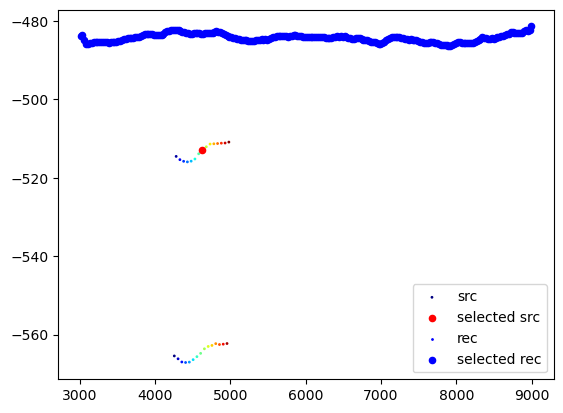

In [7]:
# Select middle shot
ishot = nSrc // 2
# Extract the shot gather from the numpy array
shot = sg.get_shotgather(ishot)['P']

# Visualize where the selected shot is located
sg.selectsrcs(ishot, ishot+1, plotflag=0)
sg.showgeometry(local=True)

Estimate direct wave arrival using sea water velocity of 1480 m/s.

In [8]:
# Direct wave velocity
v_dir = 1480

# Separation between receivers
drec = np.mean(np.abs(np.diff(sg.recx_local)))

# Compute offset for the given shot
offset = np.sqrt((sg.srcx_local[ishot] - sg.recx_local) ** 2 + (sg.srcy_local[ishot] - sg.recy_local) ** 2)
# Rearrange the offset to start from the source
offsetreg = np.linspace(-offset[0], offset[-1], nRec)

# Obtain the total distance from source to receivers 
distance = np.sqrt((sg.srcz[ishot] - sg.recz) ** 2 + \
                   (sg.srcx_local[ishot] - sg.recx_local) ** 2 + \
                   (sg.srcy_local[ishot] - sg.recy_local) ** 2)
                   
# Compute DW traveltimes
tdir = distance / v_dir

Apply gain to correct for geometrical spreading and antialiasing filter to the shot.

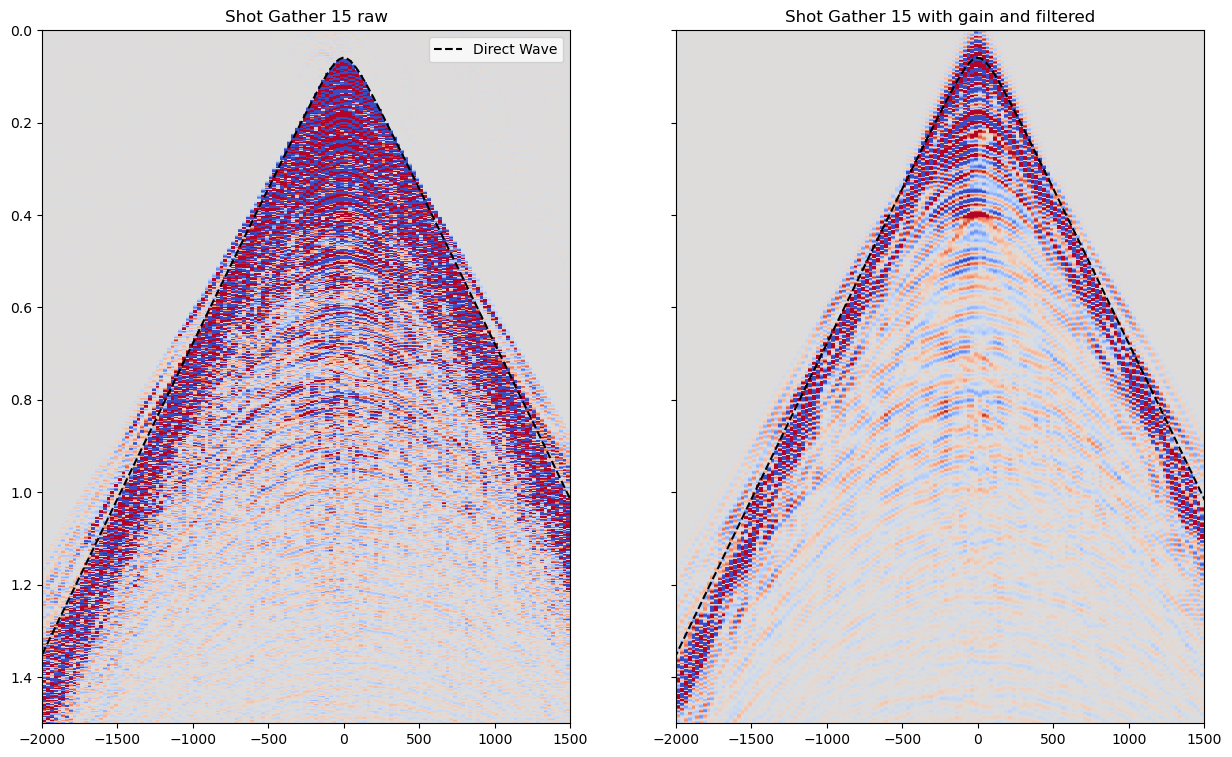

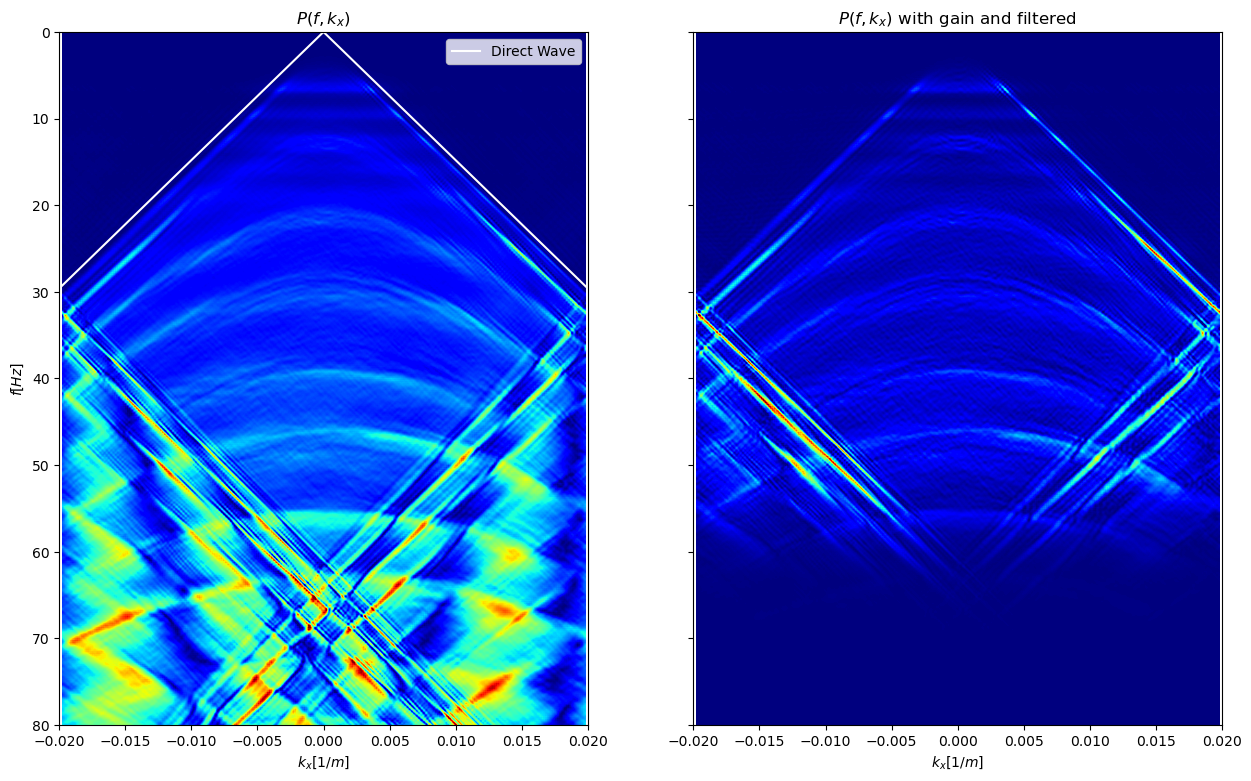

In [9]:
# Apply FFT2 to the original shot gather
shot_fk = np.fft.fft2(shot, s=(nRec, nT))

# Create a gain function
tgain = np.sqrt(sg.t)
shot_gain = (shot.T * tgain[:, np.newaxis]).T

# Define filter parameters
cutoff = 55.  # Hz
order = 11

# Apply low pass butterworth filter
shot_filt = butter_lowpass_filter(shot_gain, cutoff, 1/sg.dt, order)

# Compute the FFT2 on the filtered shot gather
shot_filt_fk = np.fft.fft2(shot_filt, s=(nRec, nT))

# Compute frequency and wavenumber axes
freq = np.fft.fftfreq(nT, dt)
kx = np.fft.fftfreq(nRec, drec)

# Display and compare the original and filtered shot gathers
vmax = 1e6
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15, 9))
axs[0].imshow(shot.T, cmap='coolwarm', vmin=-vmax, vmax=vmax,
          extent=(offsetreg[0], offsetreg[-1], t[-1], t[0]), interpolation='none')
axs[0].set_title(f'Shot Gather {ishot} raw')
axs[0].axis('tight')
axs[0].plot(offsetreg, tdir, '--k', label='Direct Wave')  # DW
axs[0].legend()
axs[1].imshow(shot_filt.T, cmap='coolwarm', vmin=-vmax, vmax=vmax,
          extent=(offsetreg[0], offsetreg[-1], t[-1], t[0]), interpolation='none')
axs[1].set_title(f'Shot Gather {ishot} with gain and filtered')
axs[1].axis('tight')
axs[1].set_xlim(-2000, 1500)
axs[1].set_ylim(1.5, 0);
axs[1].plot(offsetreg, tdir, '--k')  # DW

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(15, 9))
axs[0].imshow(np.fft.fftshift(np.abs(shot_fk[:, :nT//2-1]), axes=0).T, cmap='jet', interpolation='sinc',
              extent = (-kx[nRec//2-1], kx[nRec//2-1], freq[nT//2-1], freq[0]))
axs[0].plot(np.abs(freq[0:nT//2])/v_dir, freq[0:nT//2], 'w', label='Direct Wave')   # DW
axs[0].plot(-np.abs(freq[0:nT//2])/v_dir, freq[0:nT//2], 'w')  # DW
axs[0].set_title(r'$P(f,k_x)$')
axs[0].set_ylabel(r'$f [Hz]$')
axs[0].set_xlabel(r'$k_x [1/m]$')
axs[0].axis('tight')
axs[0].set_xlim(-0.02, 0.02)
axs[0].legend()

axs[1].imshow(np.fft.fftshift(np.abs(shot_filt_fk[:, :nT//2-1]), axes=0).T, cmap='jet', interpolation='sinc',
              extent = (-kx[nRec//2-1], kx[nRec//2-1], freq[nT//2-1], freq[0]))
# axs[1].plot(np.abs(freq[0:nT//2])/v_dir, freq[0:nT//2], 'w')   # DW
# axs[1].plot(-np.abs(freq[0:nT//2])/v_dir, freq[0:nT//2], 'w')  # DW
axs[1].set_title(r'$P(f,k_x)$ with gain and filtered')
axs[1].set_xlabel(r'$k_x [1/m]$')
axs[1].axis('tight')
axs[1].set_xlim(-0.02, 0.02)
axs[1].set_ylim(80, 0);

plt.show()

From the figure above, it is evident that applying the filter is not ideal, as it introduces artificial amplitudes at the top of the shot gather. However, since our primary objective is to accurately pick the first arrivals, antialiasing is unnecessary in this context. Instead, we will apply a simple gain to correct for geometrical spreading, but only after 1 second to avoid damping the already weak amplitudes of the first arrivals.

In [10]:
# Identify the index of the time axis where t = 1s
ind_t = np.where(t == 1)[0][0]

# Amplify amplitudes beyond 1 second with the tgain function
shot[:, ind_t:] = (shot[:, ind_t:].T * tgain[ind_t:, np.newaxis]).T

## First Break Picking: one shot 

The **first arrival time** refers to the earliest time at which a seismic wave arrives at a sensor or receiver.

### -1st approach: threshold trace by trace

The first approach is to set the threshold as a percentage of the maximum amplitude of the trace.

First significant amplitude at time 0.46s with value -753261.19


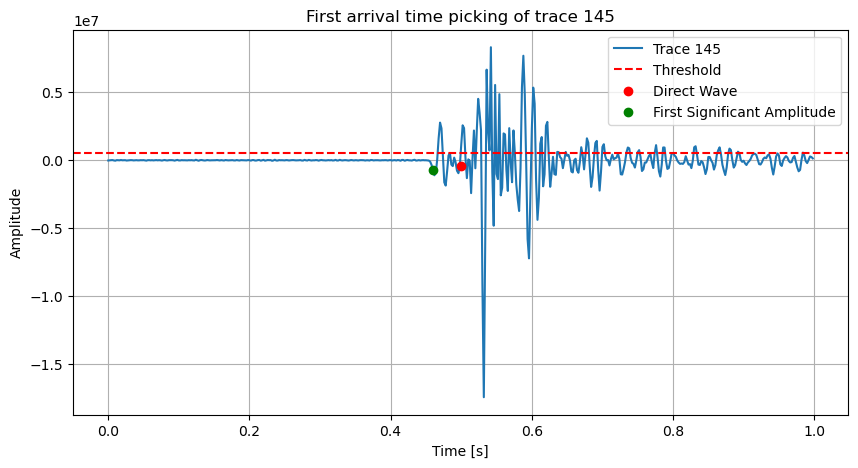

In [11]:
# Obtain parameters for the picking
ind_src = np.argmin(np.abs(offsetreg))    # index of src

#  1. Select one trace from the shot gather
tr = 145
signal = shot[tr]  # Sinusoidal signal

# 2. Set the threshold
threshold = 0.03 * np.max(np.abs(signal))  

# 3. Find the first significant amplitude
significant_indices = np.where(np.abs(signal) > threshold)[0]  # Find index
if significant_indices.size > 0:
    first_index = significant_indices[0]  # First significant index
    first_time = t[first_index]  # Corresponding time
    first_amplitude = signal[first_index]  # Corresponding amplitude
    print(f"First significant amplitude at time {first_time:.2f}s with value {first_amplitude:.2f}")
else:
    print("No significant amplitude found!")

ind_t = np.where(sg.t == 1)[0][0]         # take the first 1 second of the signal

# 4. Plot the signal and highlight the first significant amplitude
plt.figure(figsize=(10, 5))
plt.plot(t[:ind_t], signal[:ind_t], label=f"Trace {tr}")
plt.axhline(threshold, color="r", linestyle="--", label="Threshold")
plt.scatter(tdir[tr], signal[int(tdir[tr]/dt)], color="r", label="Direct Wave", zorder=5)
if significant_indices.size > 0:
    plt.scatter(first_time, first_amplitude, color="g", label="First Significant Amplitude", zorder=5)
plt.title(f"First arrival time picking of trace {tr}")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

In [12]:
# Create empty lists to store the picked indices and times
picks_idx = []
picks_ti = []

# Loop over all traces
for rec in range(nRec):
    trace = shot[rec]  #
    threshold = 0.02 * np.max(np.abs(trace))
    significant_indices = np.where(np.abs(trace) > threshold)[0]
    if significant_indices.size > 0:
        first_index = significant_indices[0]  # First significant index
        first_time = t[first_index]  # Corresponding time
    picks_idx.append(first_index)
    picks_ti.append(first_time)
    
# 5. Smooth the adjusted times with gaussian smoothing
picks_ti = sp.ndimage.gaussian_filter1d(picks_ti, sigma=2)  # Gaussian smoothing

# 4. Enforce proximity condition between neighboring signals
proximity_tolerance = 0.01  # Max allowed time difference between neighbors
adjusted_times = picks_ti.copy()

for i in range(1, len(picks_ti)):
    if abs(adjusted_times[i] - adjusted_times[i - 1]) > proximity_tolerance:
        adjusted_times[i] = (adjusted_times[i - 1] + adjusted_times[i]) / 2  # Average with the previous neighbor

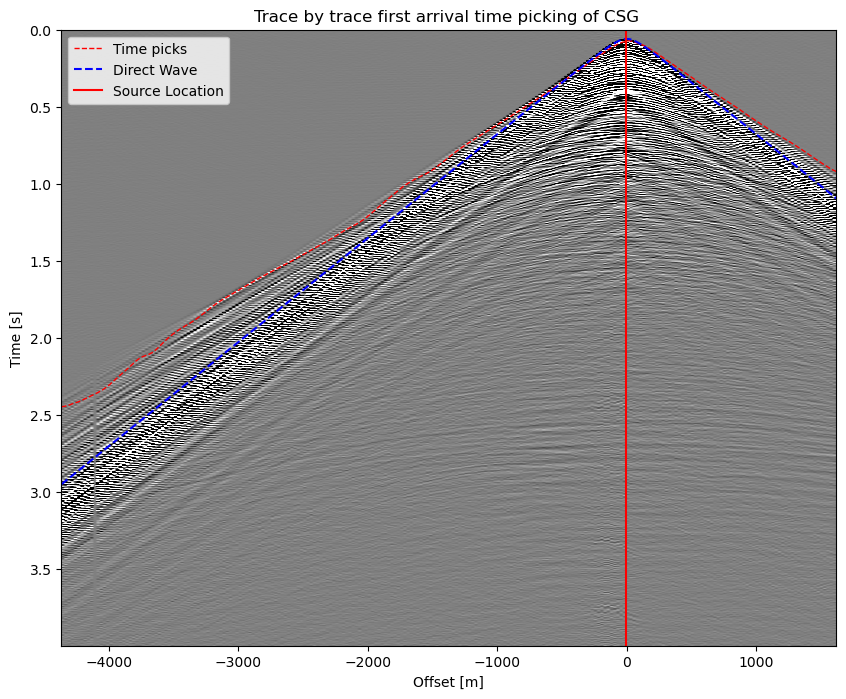

In [13]:
# Display shot gather and picked times

vmax = 3e5
plt.figure(figsize=(10, 8))
plt.imshow(shot.T, cmap='gray', vmin=-vmax, vmax=vmax,\
 extent=(offsetreg[0], offsetreg[-1], sg.t[-1], sg.t[0]))
plt.plot(offsetreg, adjusted_times, '--r', lw=1, label='Time picks')
plt.plot(offsetreg, tdir, '--b', label='Direct Wave')  # DW
plt.title(f'Trace by trace first arrival time picking of CSG ')
plt.xlabel('Offset [m]')
plt.ylabel('Time [s]')
plt.axvline(x=offsetreg[ind_src], color='red', linestyle='-', label='Source Location')
plt.gca().set_aspect('auto')
plt.legend()

plt.show()

### -2nd approach: threshold for different offsets

The second approach is to set to a number times the average amplitude of a window in the background of the shot gather. We divide our CSG in three different offsets (near, mid, and far) and decrease the threshold as the offset increases.

In [14]:
# # Obtain parameters for the picking
ind_src = np.argmin(np.abs(offsetreg))    # index of src

# Create window size
ntwin = 300   # time samples
nxwin = 50    # offset samples

# Window starting on top 
twin = (0, ntwin)

# Right side of the shot gather
if ind_src < nRec // 2:
    rwin = (nRec-nxwin, nRec)
# Left side of the shot gather
else:
    rwin = (0, nxwin)

# 1. Extract data window
dwin = shot[rwin[0]:rwin[1], twin[0]:twin[1]]
# Compute the average amplitude of the data window
dwinave = np.mean(np.abs(dwin))

# Choose offset intervals
recn_thrs_mid = 30  # Number of receivers threshold for mid offset
recn_thrs_far = 70  # Number of receivers threshold for far offset

# Set threshold values
thresh_near = 50
thresh_mid = 20
thresh_far = 7

# 2. Set a global threshold
global_threshold_near = thresh_near * dwinave 
global_threshold_mid = thresh_mid * dwinave 
global_threshold_far = thresh_far * dwinave

# Create masks for the data

# Near offset
dmask_near = np.abs(shot) > global_threshold_near  
# Put to zero traces beyond 30 receivers from the source
dmask_near[:ind_src-recn_thrs_mid] = 0
dmask_near[ind_src+recn_thrs_mid:] = 0

# Mid offset
dmask_mid = np.abs(shot) > global_threshold_mid   
# Put to zero traces below 30 receivers from the source 
# and beyond 70 receivers
dmask_mid[ind_src-recn_thrs_mid:ind_src+recn_thrs_mid] = 0
dmask_mid[:ind_src-recn_thrs_far] = 0
dmask_mid[ind_src+recn_thrs_far:] = 0

# Far offset 
dmask_far = np.abs(shot) > global_threshold_far   
# Put to zero traces below the rest of the receivers
dmask_far[ind_src-recn_thrs_far:ind_src+recn_thrs_far] = 0

In [15]:
# 3. Find the first significant amplitude for each signal
picks_idx = []
picks_ti = []

error_threshold = 0.2  # sec. Possibly a dead trace

for rec in range(nRec):
    # Near offset
    if ind_src-recn_thrs_mid < rec < ind_src+recn_thrs_mid:
        significant_indices = np.where(np.abs(shot[rec]) > global_threshold_near)[0]
        if significant_indices.size > 0:
            picks_idx.append(significant_indices[0])
            picks_ti.append(t[significant_indices[0]])
        else:
            picks_idx.append(picks_idx[-1])
            picks_ti.append(picks_ti[-1])
    # Mid offset
    elif ind_src-recn_thrs_far < rec < ind_src+recn_thrs_far:
        significant_indices = np.where(np.abs(shot[rec]) > global_threshold_mid)[0]
        if significant_indices.size > 0:
            picks_idx.append(significant_indices[0])
            picks_ti.append(t[significant_indices[0]])
        else:
            picks_idx.append(picks_idx[-1])
            picks_ti.append(picks_ti[-1])
    # Far offset
    else:
        significant_indices = np.where(np.abs(shot[rec]) > global_threshold_far)[0]
        if significant_indices.size > 0:
            picks_idx.append(significant_indices[0])
            picks_ti.append(t[significant_indices[0]])
        else:
            picks_idx.append(picks_idx[-1])
            picks_ti.append(picks_ti[-1])
    # Adjust the time if the difference is too large
    if len(picks_ti) > 1:
        if abs(picks_ti[-1] - picks_ti[-2]) > error_threshold:
            picks_ti[-1] = picks_ti[-2]
        
# 4. Smooth the adjusted times
picks_ti = sp.ndimage.gaussian_filter1d(picks_ti, sigma=2)  # Gaussian smoothing

# 5. Enforce proximity condition between neighboring signals
proximity_tolerance = 0.01  # sec. Max allowed time difference between neighbors
adjusted_ti = picks_ti.copy()

for i in range(1, len(picks_ti)):
    if abs(adjusted_ti[i] - adjusted_ti[i - 1]) > proximity_tolerance:
        adjusted_ti[i] = (adjusted_ti[i - 1] + adjusted_ti[i]) / 2  # Average with the neighbor

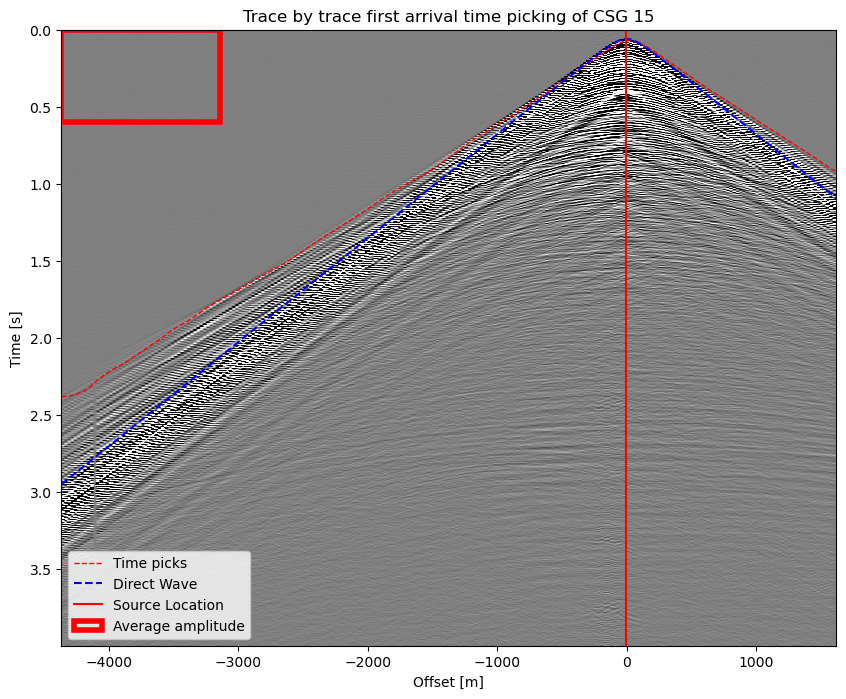

In [16]:
# Display shot gather and picked times
vmax = 3e5
plt.figure(figsize=(10, 8))
plt.imshow(shot.T, cmap='gray', vmin=-vmax, vmax=vmax,\
 extent=(offsetreg[0], offsetreg[-1], t[-1], t[0]))
plt.plot(offsetreg, adjusted_ti, '--r', lw=1, label='Time picks')
plt.plot(offsetreg, tdir, '--b', label='Direct Wave')  # DW
plt.title(f'Trace by trace first arrival time picking of CSG {ishot}')
plt.xlabel('Offset [m]')
plt.ylabel('Time [s]')
plt.axvline(x=offsetreg[ind_src], color='red', linestyle='-', label='Source Location')

# Plot window
ax = plt.gca()
rect = Rectangle((offsetreg[rwin[0]], t[twin[0]]), offsetreg[rwin[1]-1]-offsetreg[rwin[0]], t[twin[1]-1]-t[twin[0]], 
                 edgecolor='red', facecolor='none', lw=4, label='Average amplitude')
ax.add_patch(rect)
plt.gca().set_aspect('auto')
plt.legend()

plt.show()

There is a clear improvement by taking three different offsets to choose the threshold. Now show which amplitudes are 'seen' by these masks.

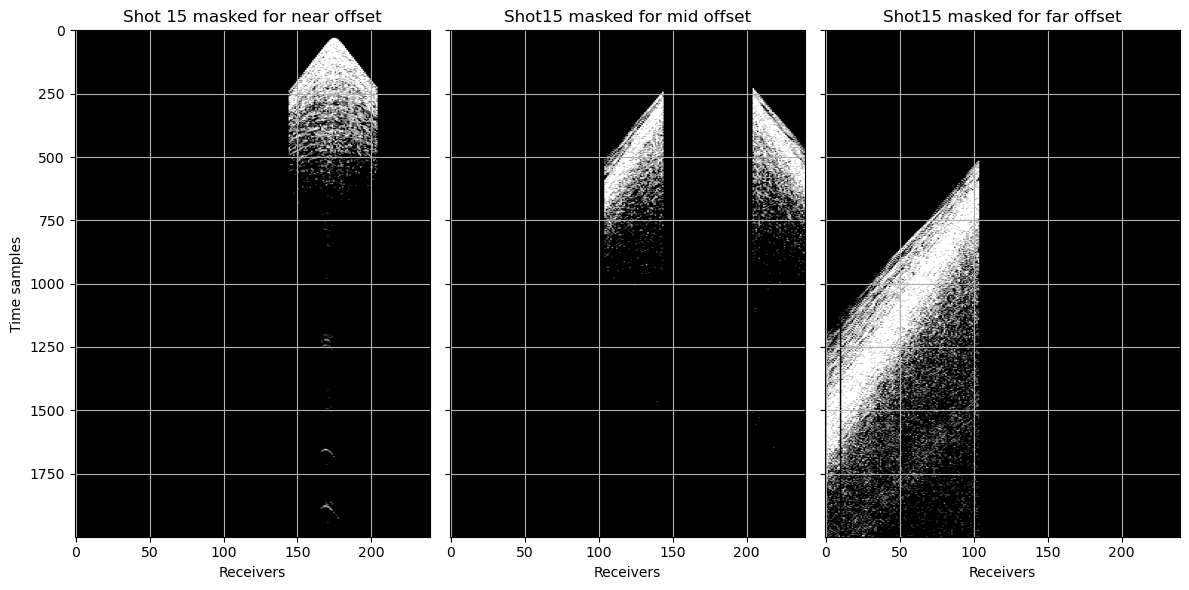

In [17]:
# Show the data masked for the three intervals
fig, axes = plt.subplots(1, 3, figsize=(12, 6), sharey=True)  # 1 row, 2 columns

# Plot near offset mask
im1 = axes[0].imshow(dmask_near.T, cmap='gray')
axes[0].set_title(f'Shot {ishot} masked for near offset')
axes[0].set_xlabel('Receivers')
axes[0].set_ylabel('Time samples')
axes[0].grid(which='both')
axes[0].set_aspect('auto')

# Plot mid offset mask
im2 = axes[1].imshow(dmask_mid.T, cmap='gray')
axes[1].set_title(f'Shot{ishot} masked for mid offset')
axes[1].set_xlabel('Receivers')
axes[1].grid(which='both')
axes[1].set_aspect('auto')

# Plot far offset mask
im3 = axes[2].imshow(dmask_far.T, cmap='gray')
axes[2].set_title(f'Shot{ishot} masked for far offset')
axes[2].set_xlabel('Receivers')
axes[2].grid(which='both')
axes[2].set_aspect('auto')

plt.tight_layout()
plt.show()

## First Break Picking: all shots

We apply the **second approach** to obtain the first arrival traveltimes of all CSGs.

In [18]:
# Create empty lists to store the picked indices and times
tfirsts = []

for src in range(nSrc):
    print(f"Start picking shot {src}")
    shot = sg.get_shotgather(src)['P']
    # Compute offset for the given shot
    offset = np.sqrt((sg.srcx_local[src] - sg.recx_local) ** 2 \
        + (sg.srcy_local[src] - sg.recy_local) ** 2)
    # Rearrange the offset to start from the source
    offsetreg = np.linspace(-offset[0], offset[-1], nRec)
    # Get the source index
    ind_src = np.argmin(np.abs(offsetreg))

    # Apply gain function from the 1st second
    shot[:, ind_t:] = (shot[:, ind_t:].T * tgain[ind_t:, np.newaxis]).T     
    
    # Use same window size and threshold values as before

    # Choose where to locate the window
    if ind_src < nRec // 2:
        rwin = (nRec-nxwin, nRec)
    else:
        rwin = (0, nxwin)

    # 1. Extract data window
    dwin = shot[rwin[0]:rwin[1], twin[0]:twin[1]]
    dwinave = np.mean(np.abs(dwin))

    # 2. Set a global threshold
    global_threshold_near = thresh_near * dwinave
    global_threshold_mid = thresh_mid * dwinave
    global_threshold_far = thresh_far * dwinave

    # 3. Find the first significant amplitude for each signal
    picks_idx = []
    picks_ti = []

    error_threshold = 0.2  # sec. Possibly a dead trace

    for rec in range(nRec):
        # Near offset
        if ind_src-recn_thrs_mid < rec < ind_src+recn_thrs_mid:
            significant_indices = np.where(np.abs(shot[rec]) > global_threshold_near)[0]
            if significant_indices.size > 0:
                picks_idx.append(significant_indices[0])
                picks_ti.append(t[significant_indices[0]])
            else:
                picks_idx.append(picks_idx[-1])
                picks_ti.append(picks_ti[-1])
        # Mid offset
        elif ind_src-recn_thrs_far < rec < ind_src+recn_thrs_far:
            significant_indices = np.where(np.abs(shot[rec]) > global_threshold_mid)[0]
            if significant_indices.size > 0:
                picks_idx.append(significant_indices[0])
                picks_ti.append(t[significant_indices[0]])
            else:
                picks_idx.append(picks_idx[-1])
                picks_ti.append(picks_ti[-1])
        # Far offset
        else:
            significant_indices = np.where(np.abs(shot[rec]) > global_threshold_far)[0]
            if significant_indices.size > 0:
                picks_idx.append(significant_indices[0])
                picks_ti.append(t[significant_indices[0]])
            else:
                picks_idx.append(picks_idx[-1])
                picks_ti.append(picks_ti[-1])
        # Adjust the time if the difference is too large
        if len(picks_ti) > 1:
            if abs(picks_ti[-1] - picks_ti[-2]) > error_threshold:
                picks_ti[-1] = picks_ti[-2]
            
    # 4. Smooth the adjusted times
    picks_ti = sp.ndimage.gaussian_filter1d(picks_ti, sigma=2)  # Gaussian smoothing

    # 5. Enforce proximity condition between neighboring signals
    proximity_tolerance = 0.01  # sec. Max allowed time difference between neighbors
    adjusted_ti = picks_ti.copy()

    for i in range(1, len(picks_ti)):
        if abs(adjusted_ti[i] - adjusted_ti[i - 1]) > proximity_tolerance:
            adjusted_ti[i] = (adjusted_ti[i - 1] + adjusted_ti[i]) / 2  # Average with the neighbor
        
    tfirsts.append(adjusted_ti)

Start picking shot 0
Start picking shot 1
Start picking shot 2
Start picking shot 3
Start picking shot 4
Start picking shot 5
Start picking shot 6
Start picking shot 7
Start picking shot 8
Start picking shot 9
Start picking shot 10
Start picking shot 11
Start picking shot 12
Start picking shot 13
Start picking shot 14
Start picking shot 15
Start picking shot 16
Start picking shot 17
Start picking shot 18
Start picking shot 19
Start picking shot 20
Start picking shot 21
Start picking shot 22
Start picking shot 23
Start picking shot 24
Start picking shot 25
Start picking shot 26
Start picking shot 27
Start picking shot 28
Start picking shot 29


In [19]:
# Convert the list to a numpy array
tfirsts = np.vstack(tfirsts)
tfirsts.shape

(30, 240)

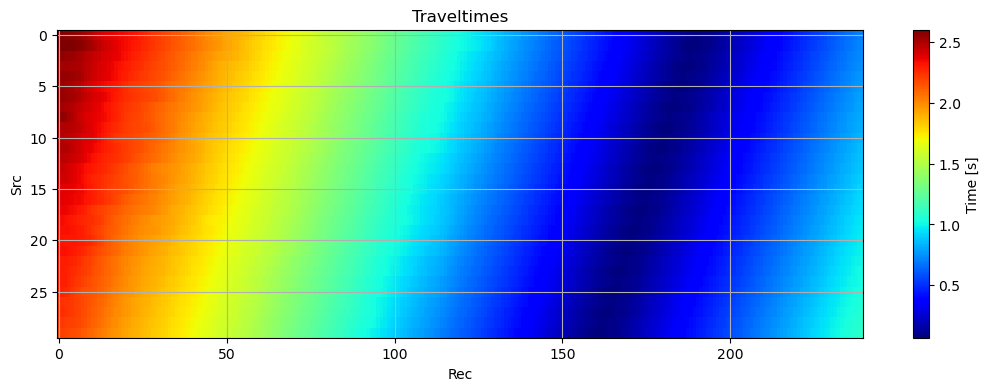

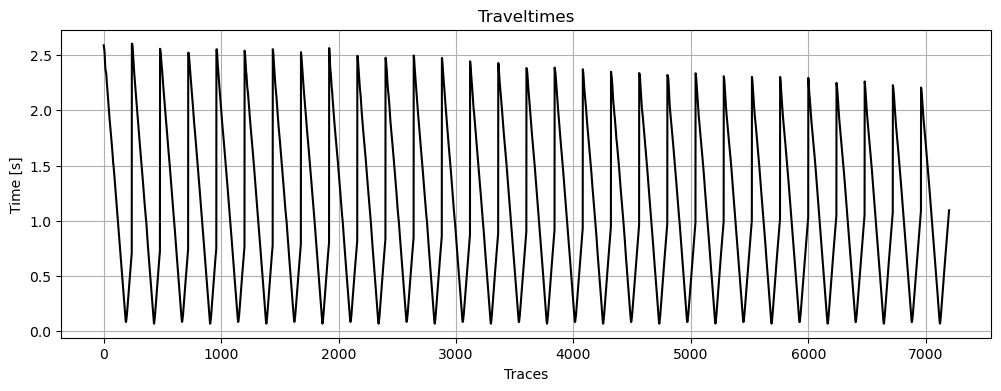

In [20]:
# Plot the traveltimes matrix
plt.figure(figsize=(13, 4))
plt.imshow(tfirsts, cmap='jet')
plt.axis('tight')
plt.xlabel('Rec')
plt.ylabel('Src')
plt.title('Traveltimes')
plt.grid(which='both')
plt.colorbar(label='Time [s]');

# Plot the traveltimes ravel
plt.figure(figsize=(12, 4))
plt.plot(tfirsts.ravel(), 'k')
plt.axis('tight')
plt.ylabel('Time [s]')
plt.xlabel('Traces')
plt.title('Traveltimes')
plt.grid(which='both')

After doing QC on some results, and observing reasonable traveltimes for our dataset, we proceed to save the traveltimes for later use.

In [21]:
# Save the traveltimes
np.savez('../data/FirstArrivalVolve', tfirst=tfirsts)